## Goals
From an unlabeled video, we want **Random sequences** of frames. 
This will allow us to leverage unlabeled frames for PPCA and temporal penalties together. 
For comparing models, make sure we're using the **same random seed** when initializing `video_pipe`. 
Also, keep some unlabeled videos for training and some for testing.

In [1]:
import os
import numpy as np

from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
import nvidia.dali.types as types

In [2]:
%load_ext autoreload
%autoreload 2

In [22]:
# From tutorial, changing these params for our video
batch_size=1
sequence_length=16
initial_prefetch_size=16
n_iter=6

In [23]:
video_directory = "../../toy_datasets/toymouseRunningData/unlabeled_videos"

assert os.path.exists(video_directory)
video_files = [video_directory + "/" + f for f in os.listdir(video_directory)]
print(video_files)
vids = []
for (
    f
) in (
    video_files
):  # video_directory may contain other random files that are not vids, DALI will try to read them
    if f.endswith(".mp4"):  # hardcoded for the toydataset folder
        vids.append(f)

['../../toy_datasets/toymouseRunningData/unlabeled_videos/.ipynb_checkpoints', '../../toy_datasets/toymouseRunningData/unlabeled_videos/test_vid.mp4']


In [24]:
print("video at: {}".format(vids))

video at: ['../../toy_datasets/toymouseRunningData/unlabeled_videos/test_vid.mp4']


In [25]:
@pipeline_def
def video_pipe(filenames):
    videos = fn.readers.video(device="gpu", filenames= filenames, sequence_length=sequence_length,
                              shard_id=0, num_shards=1, random_shuffle=False, initial_fill=initial_prefetch_size)
    return videos

In [26]:
pipe = video_pipe(batch_size=batch_size, num_threads=2, device_id=0, filenames=vids, seed=123456)
pipe.build()
for i in range(n_iter):
    pipe_out = pipe.run()
    sequences_out = pipe_out[0].as_cpu().as_array()
    print(sequences_out.shape)

(1, 16, 406, 396, 3)
(1, 16, 406, 396, 3)
(1, 16, 406, 396, 3)
(1, 16, 406, 396, 3)
(1, 16, 406, 396, 3)
(1, 16, 406, 396, 3)


[/opt/dali/dali/operators/reader/loader/video_loader.h:177] ``file_list_include_preceding_frame`` is set to False (or not set at all). In future releases, the default behavior would be changed to True.


In [27]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

In [37]:
def show_sequence(sequence, ind):
    columns = 4
    rows = (sequence_length + 1) // (columns)
    fig = plt.figure(figsize = (32,(16 // columns) * rows))
    fig.suptitle("sequence number {}".format(ind))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(sequence[j])
        

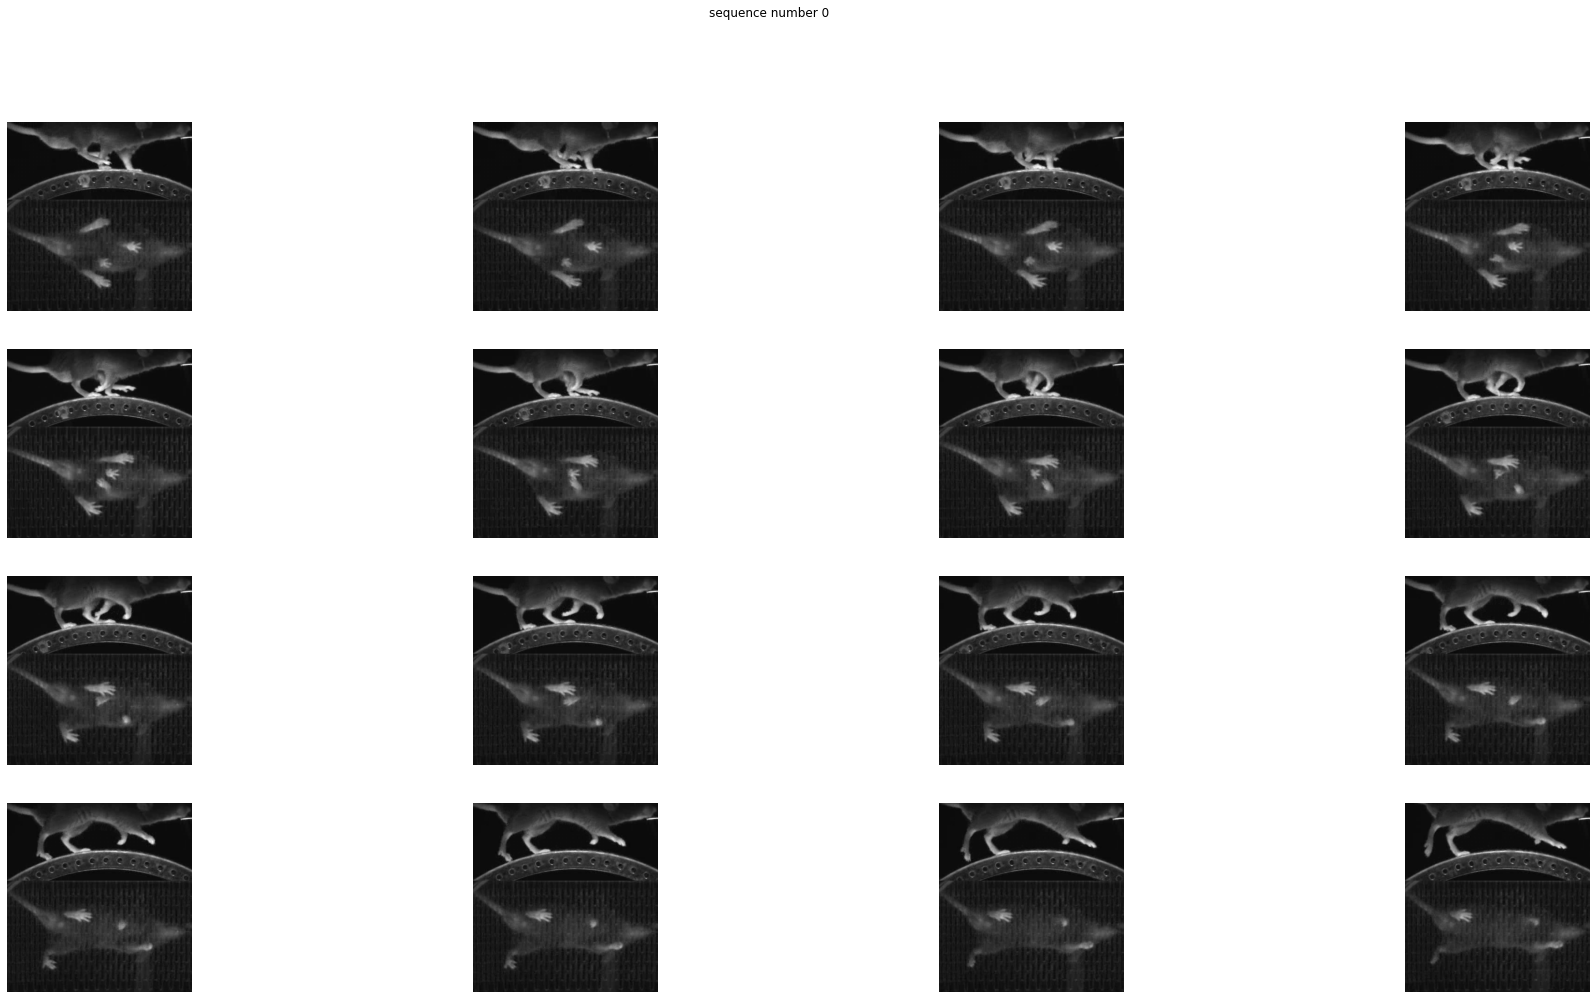

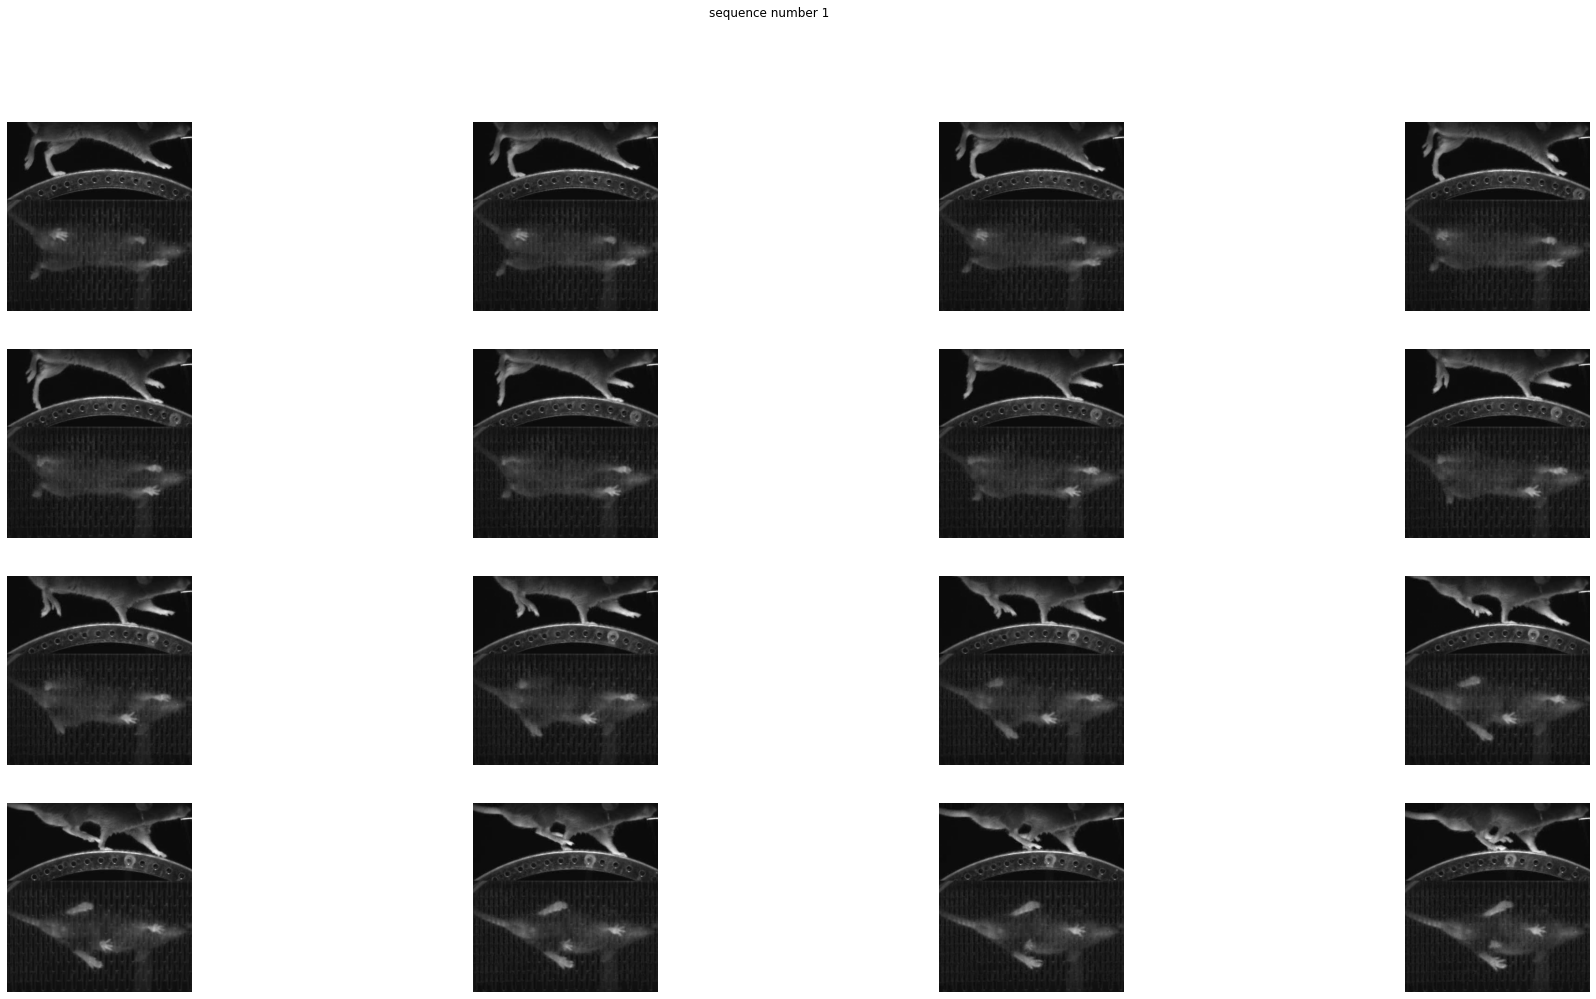

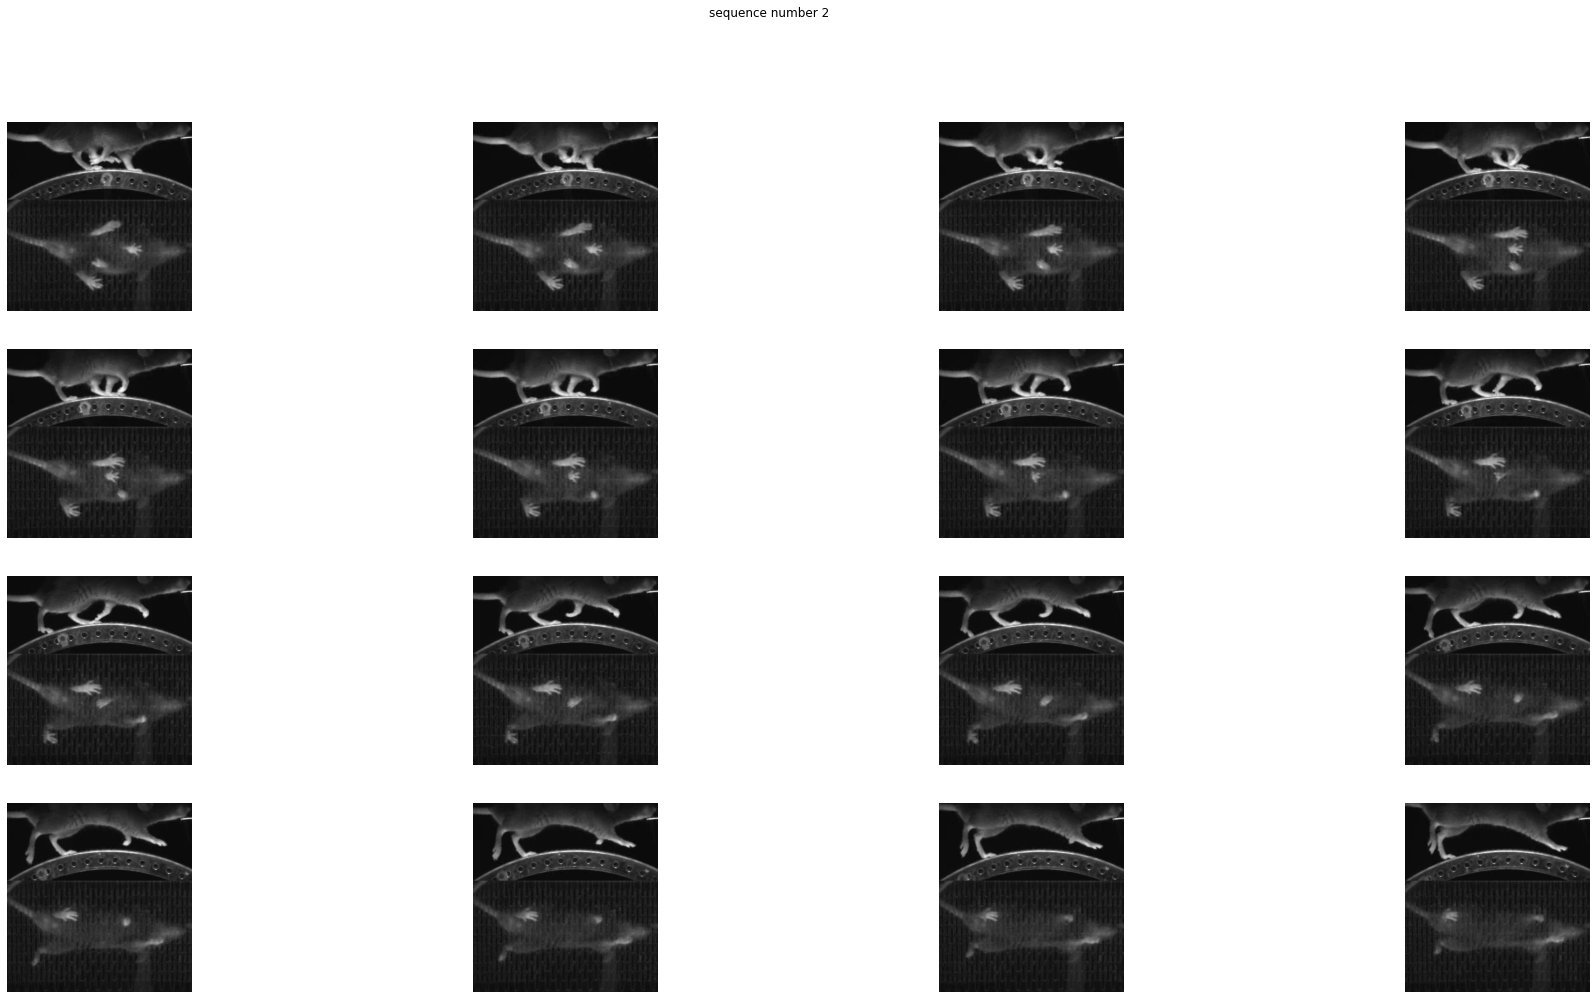

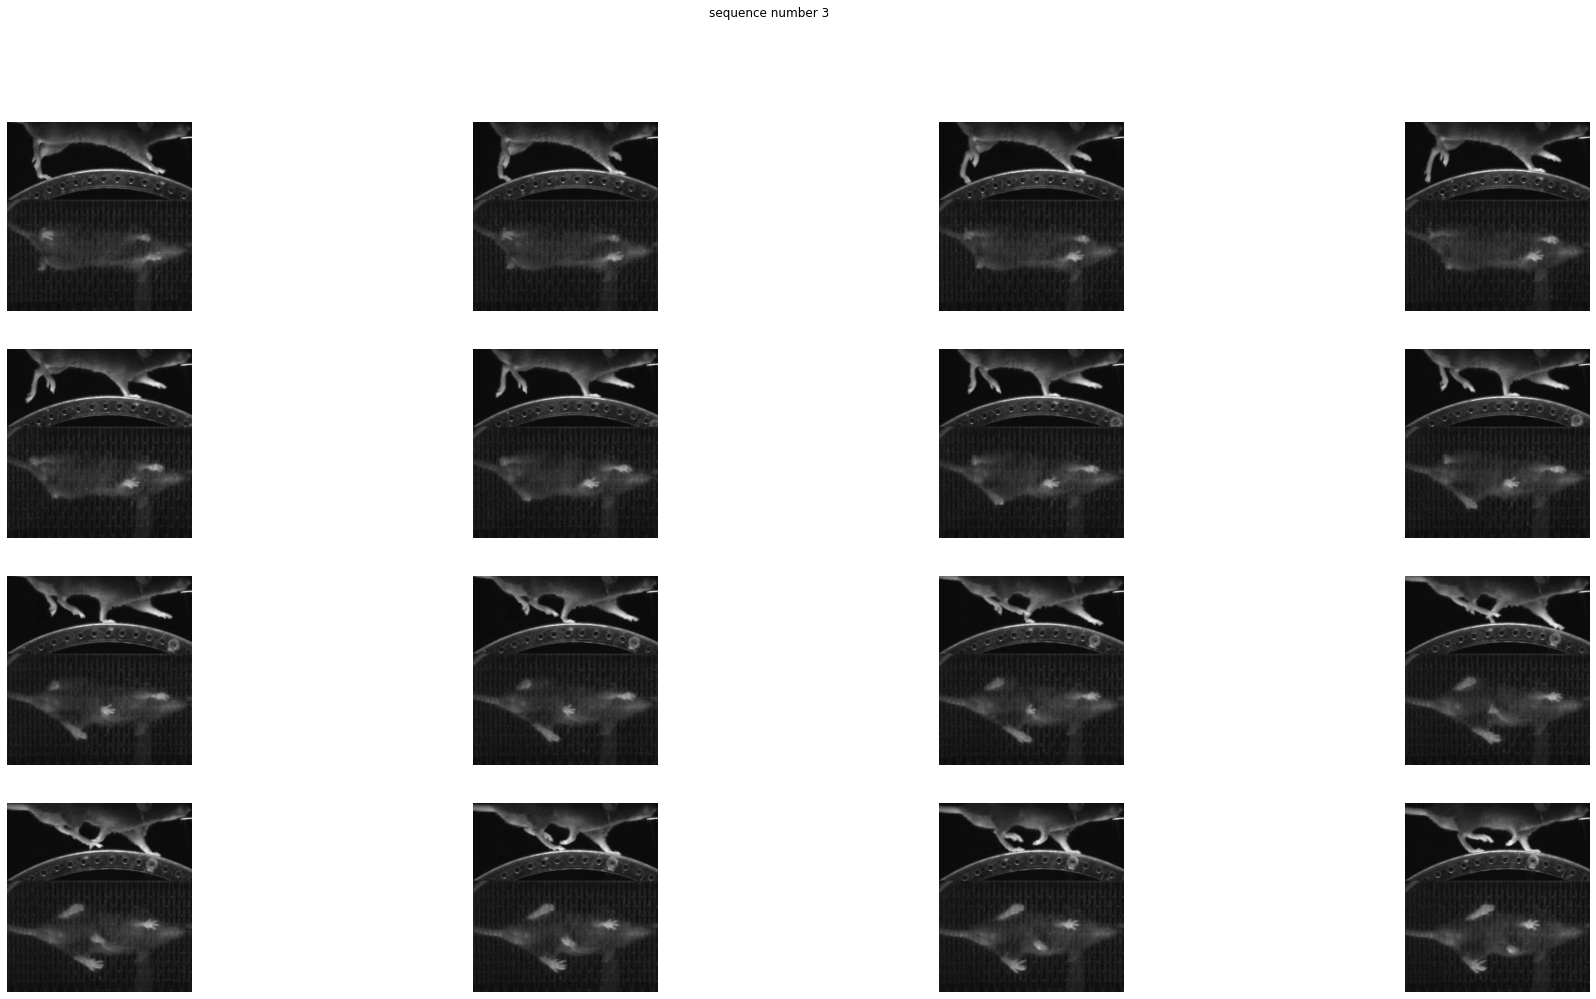

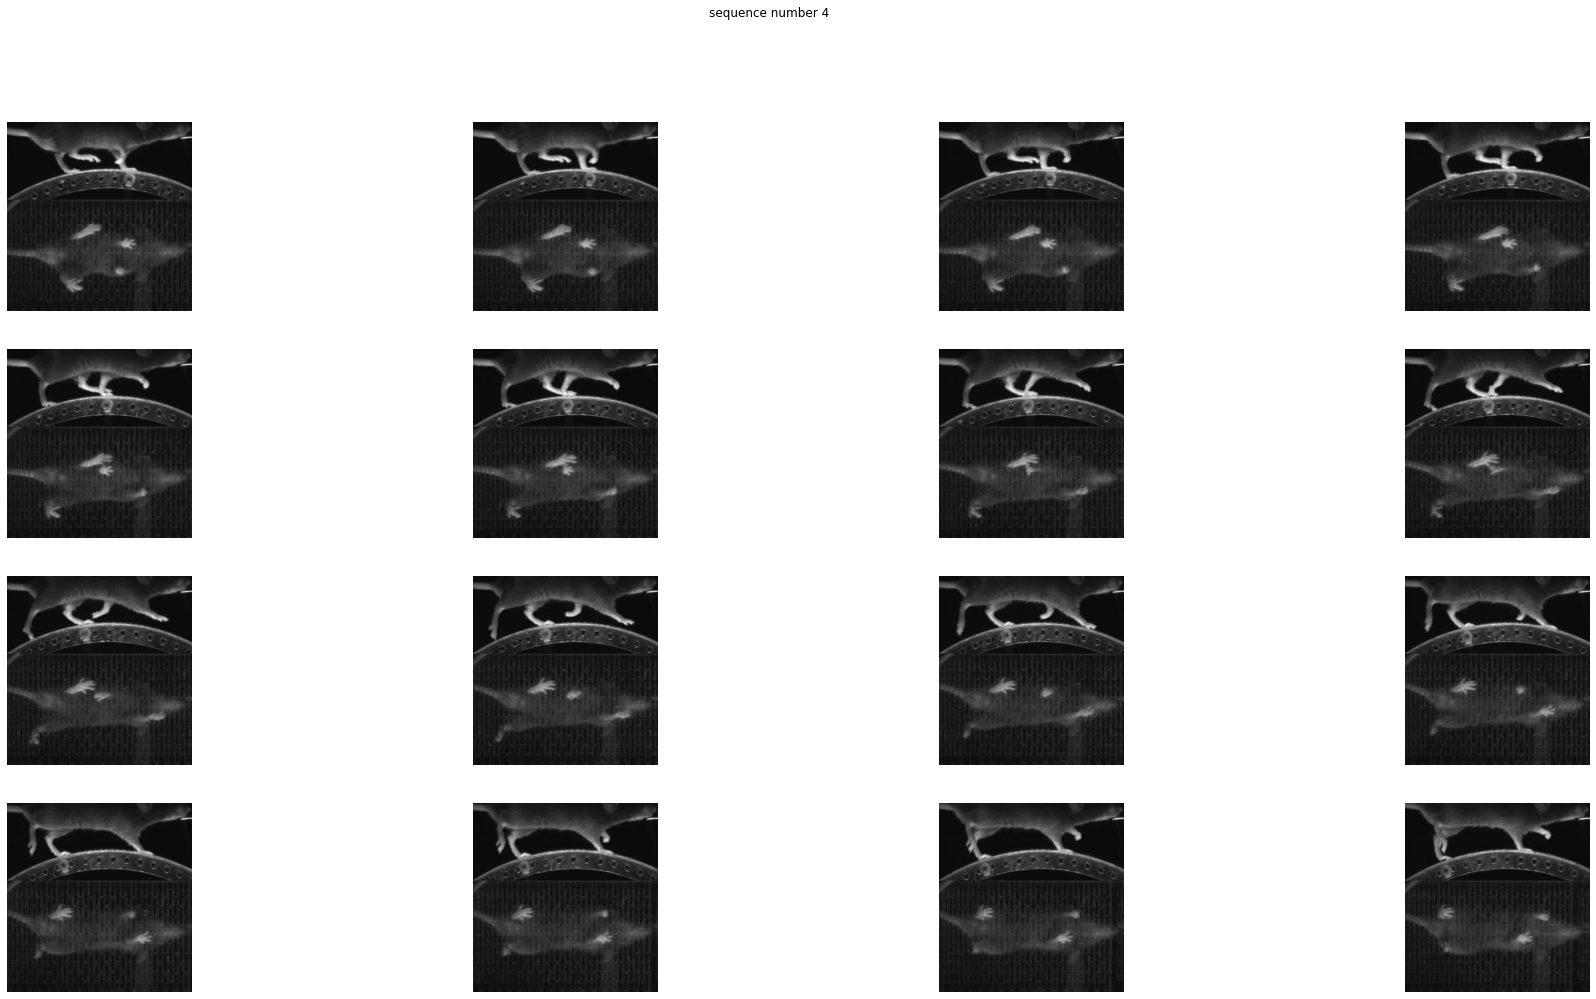

In [38]:
import time
for ind in range(5):
    pipe_out = pipe.run()
    sequences_out = pipe_out[0].as_cpu().as_array()
    show_sequence(sequences_out[0], ind)

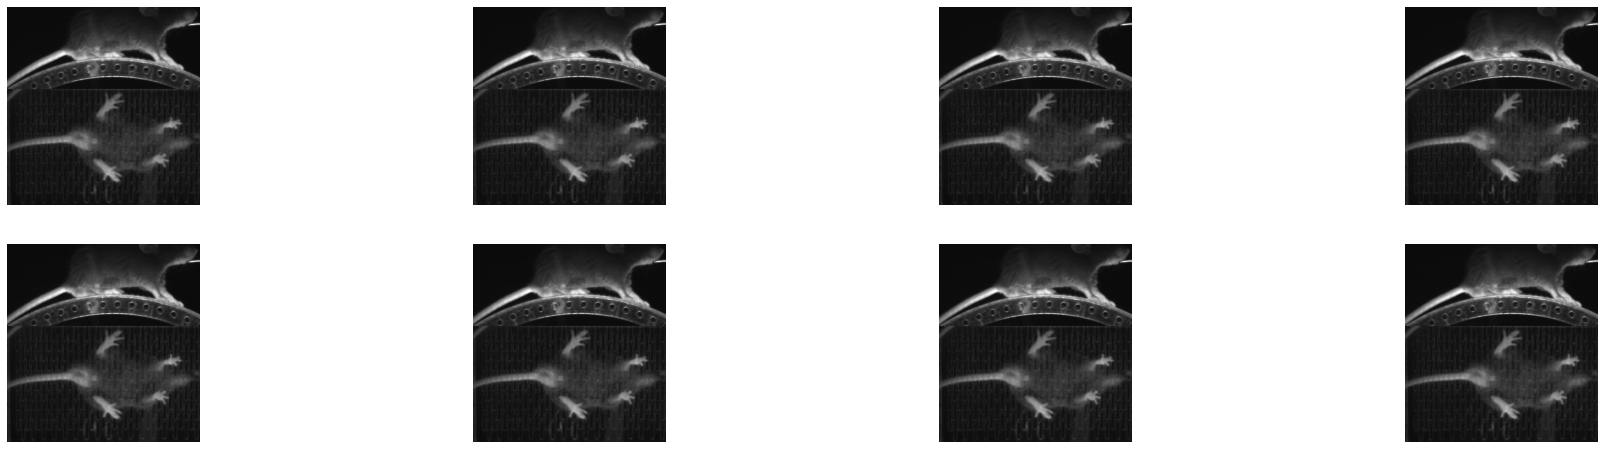

In [9]:
show_sequence(sequences_out[1])

In [10]:
print("min pix val= {}, max pix val = {}".format(np.min(sequences_out), np.max(sequences_out)))

min pix val= 0, max pix val = 255


In [93]:
from pose_est_nets.datasets.datasets import DLCHeatmapDataset, TrackingDataModule, BaseTrackingDataset

ImportError: cannot import name 'DLCHeatmapDataset' from 'pose_est_nets.datasets.datasets' (/home/jovyan/pose-estimation-nets/pose_est_nets/datasets/datasets.py)

In [16]:
test_ls = []
test_ls.append(1)
test_ls.append(2)
test_ls.append([1,2])
test_ls += [1, 2]

test_ls

[1, 2, [1, 2], 1, 2]

In [30]:
# TODO: remove to test
# TODO: mode naming isn't good here and below
# TODO: data transform
# Hardcoded for fish data for now, in the future we can have feature which will automatically check if a data_transform needs to be applied and select the right transformation
import imgaug.augmenters as iaa
data_transform = []
data_transform.append(
    iaa.Resize({"height": 384, "width": 384})
)  # dlc dimensions need to be repeatably divisable by 2

data_transform = iaa.Sequential(data_transform)
full_data = BaseTrackingDataset(
        root_directory=os.path.join('/home/jovyan/mouseRunningData'),
        csv_path="CollectedData_.csv",
        header_rows=[1, 2],
        pytorch_transform_list=None,
        imgaug_transform=data_transform,
    )

In [32]:
print(full_data.__len__())
test_item = full_data.__getitem__(20)
print("test_item shape: {} keypoints shape {}".format(test_item[0].shape, test_item[1].shape))

1045
image.shape: (1, 406, 396, 3)
keypoints.shape: (1, 17, 2)
test_item shape: torch.Size([3, 384, 384]) keypoints shape (17, 2)


In [21]:
# TODO: mode naming isn't good here and below
# TODO: data transform
# Hardcoded for fish data for now, in the future we can have feature which will automatically check if a data_transform needs to be applied and select the right transformation
import imgaug.augmenters as iaa
data_transform = []
data_transform.append(
    iaa.Resize({"height": 384, "width": 384})
)  # dlc dimensions need to be repeatably divisable by 2
data_transform = iaa.Sequential(data_transform)
full_data = DLCHeatmapDataset(
        root_directory=os.path.join('/home/jovyan/mouseRunningData'),
        data_path="CollectedData_.csv",
        header_rows=[1, 2],
        mode="csv",
        noNans=True,
        transform=data_transform,
    )

/home/jovyan/pose-estimation-nets/pose_est_nets/datasets/datasets.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(self.labels)
  4%|▍         | 9/227 [00:00<00:02, 84.22it/s]

(396, 406)
(384, 384, 3)
227 227
torch.Size([227, 17, 2])


100%|██████████| 227/227 [00:02<00:00, 93.87it/s] 


34


In [22]:
datamod = TrackingDataModule(
        full_data,
        mode="random",
        train_batch_size=16,
        validation_batch_size=10,
        test_batch_size=1,
    use_unlabeled_frames=True,
    )  # dlc configs
data = full_data

datamod.setup()
datamod.setup_unlabeled(video_files)
datamod.computePPCA_params()

Setting up DataModule...
Number of labeled images in the full dataset (train+val+test): 227
Size of -- train set: 181, validation set: 23, test set: 23


[/opt/dali/dali/operators/reader/nvdecoder/nvdecoder.cc:87] Warning: Decoding on a default stream. Performance may be affected.


Computing PCA on the labels...
Done!
arr_for_pca shape: torch.Size([4, 1267])
Results of running PCA on labels:
explained_variance_ratio_: [0.887 0.071 0.041 0.001]
total_explained_var: 0.999


In [125]:
torch.mean(torch.tensor(test_arr))

tensor(0.0201, dtype=torch.float64)

In [49]:
out = next(iter(datamod.val_dataloader()))

/home/jovyan/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [50]:
print(len(out))
print(out[0].shape)
print(out[1].shape)

2
torch.Size([10, 3, 384, 384])
torch.Size([10, 17, 96, 96])


In [76]:
# # NO NEED FOR THIS. it's all in the CombinedLoader class below
# #data_loader = datamod.train_dataloader()
# data_loader = [datamod.train_dataloader()[k] for k in datamod.train_dataloader().keys()]
# print(data_loader)
# if isinstance(data_loader, dict):
#     example_batch = {k : next(iter(data_loader[k])) for k in data_loader.keys()}
# elif isinstance(data_loader, torch.utils.data.dataloader.DataLoader):
#     example_batch = next(iter(data_loader))
# elif isinstance(data_loader, list):
#     example_batch = [next(iter(data_loader[k])) for k in len(data_loader)]
# else:
#     print("Handle errors")
#     # Handle errors

[<torch.utils.data.dataloader.DataLoader object at 0x7f560d5c3700>, <torch.utils.data.dataloader.DataLoader object at 0x7f560d675760>]


TypeError: 'int' object is not iterable

In [7]:
from pytorch_lightning.trainer.supporters import CombinedLoader

loader = CombinedLoader(datamod.train_dataloader())
out = next(iter(loader))
print(type(out))
print(out.keys())
out["unlabeled"].shape


NameError: name 'datamod' is not defined

In [15]:
import torch
zeros = torch.zeros(size=(2, 3))
ones = torch.ones(size=(2, 3))
eq = torch.eq(zeros, ones)
not_eq = ~eq
boolean = zeros == ones
boolean_not = zeros != ones
assert (eq == boolean).all()
assert (not_eq == boolean_not).all()
unsqueeze_1 = torch.unsqueeze(not_eq,2)
unsqueeze_2 = torch.unsqueeze(unsqueeze_1,3)
not_eq_reshaped = torch.reshape(not_eq, [not_eq.shape[0], not_eq.shape[1], 1, 1])
assert (unsqueeze_2 == not_eq_reshaped).all()

In [93]:
#out = next(iter(datamod.train_dataloader()))

torch.Size([7, 3, 406, 396])

In [64]:
out = next(iter(datamod.train_dataloader()["unlabeled"]))

In [65]:
print(len(out))
print(out[0].shape)
print(out[1].shape)
#next(iter(datamod.semi_supervised_loader)).shape

2
torch.Size([16, 3, 384, 384])
torch.Size([16, 17, 96, 96])


In [23]:
from pose_est_nets.models.heatmap_tracker import Semi_Supervised_DLC

model = Semi_Supervised_DLC(
    num_targets=34, # TODO: this arg is problematic, can be confusing. stick to num_keypoints.
    resnet_version=18,
)

In [24]:
if 'PL_TRAINER_GPUS' in os.environ:
    os.environ.pop('PL_TRAINER_GPUS')

In [25]:
import torch
import pytorch_lightning as pl
model.pca_param_dict = datamod.pca_param_dict
model.output_shape = data.output_shape
model.output_sigma = data.output_sigma
device = "cuda" if torch.cuda.is_available() else "cpu"
model.upsample_factor = torch.tensor(100, device=device) # TODO: clarify this
model.confidence_scale = torch.tensor(255.0, device=device) # TODO: clarify

In [27]:
trainer = pl.Trainer(
    gpus=1,
    log_every_n_steps=1,
    max_epochs=3
    #profiler="pytorch"
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [28]:
trainer.fit(model=model, datamodule = datamod)

/home/jovyan/conda/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2021-09-08 18:06:40.002624: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 11.2 M
1 | upsampling_layers | Sequential | 22.2 K
-------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.795    Total estimated model params size (MB)


/home/jovyan/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/home/jovyan/conda/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/home/jovyan/conda/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecat

/home/jovyan/pose-estimation-nets/pose_est_nets/datasets/datasets.py:401: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(
/home/jovyan/pose-estimation-nets/pose_est_nets/utils/heatmap_tracker_utils.py:140: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kernel = torch.tensor(1 / (sigma * math.sqrt(2 * np.pi)), device=heatmaps.device)
/home/jovyan/pose-estimation-nets/pose_est_nets/utils/heatmap_tracker_utils.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  center = torch.stack([torch.tensor(row_center), torch.tensor(

In [20]:
from pytorch_lightning import LightningModule
import torch 

In [38]:
a = torch.tensor(np.random.normal(size = (10,12,2,2)))
assert((torch.tensor(a.shape[-2:])//2 == torch.tensor([1,1])).all())

In [24]:
class LitModel(LightningModule):
    def train_dataloader(self):

        loader_a = torch.utils.data.DataLoader(range(8), batch_size=4)
        loader_b = torch.utils.data.DataLoader(range(16), batch_size=4)
        loader_c = torch.utils.data.DataLoader(range(32), batch_size=4)
        loader_d = torch.utils.data.DataLoader(range(64), batch_size=4)

        # pass loaders as a nested dict. This will create batches like this:
        loaders = {"loaders_a_b": [loader_a, loader_b], "loaders_c_d": {"c": loader_c, "d": loader_d}}
        return loaders

    def training_step(self, batch, batch_idx):
        # access the data
        batch_a_b = batch["loaders_a_b"]
        batch_c_d = batch["loaders_c_d"]

        batch_a = batch_a_b[0]
        batch_b = batch_a_b[1]

        batch_c = batch_c_d["c"]
        batch_d = batch_c_d["d"]

In [25]:
lit_model = LitModel()

In [31]:
lit_model.train_dataloader()

{'loaders_a_b': [<torch.utils.data.dataloader.DataLoader at 0x7f95cc48b640>,
 'loaders_c_d': {'c': <torch.utils.data.dataloader.DataLoader at 0x7f95cc48b100>,
  'd': <torch.utils.data.dataloader.DataLoader at 0x7f95cc46f220>}}

In [ ]:
from ..convenience import is_cv3
import cv2
def count_frames(path, override=False):
	# grab a pointer to the video file and initialize the total
	# number of frames read
	video = cv2.VideoCapture(path)
	total = 0
	# if the override flag is passed in, revert to the manual
	# method of counting frames
	if override:
		total = count_frames_manual(video)
	# otherwise, let's try the fast way first
	else:
		# lets try to determine the number of frames in a video
		# via video properties; this method can be very buggy
		# and might throw an error based on your OpenCV version
		# or may fail entirely based on your which video codecs
		# you have installed
		try:
			# check if we are using OpenCV 3
			if is_cv3():
				total = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
			# otherwise, we are using OpenCV 2.4
			else:
				total = int(video.get(cv2.cv.CV_CAP_PROP_FRAME_COUNT))
		# uh-oh, we got an error -- revert to counting manually
		except:
			total = count_frames_manual(video)
	# release the video file pointer
	video.release()
	# return the total number of frames in the video
	return total
def count_frames_manual(video):
	# initialize the total number of frames read
	total = 0
	# loop over the frames of the video
	while True:
		# grab the current frame
		(grabbed, frame) = video.read()
	 
		# check to see if we have reached the end of the
		# video
		if not grabbed:
			break
		# increment the total number of frames read
		total += 1
	# return the total number of frames in the video file
	return total

In [4]:
import cv2

In [8]:
video_full_path = "/home/jovyan/mouseRunningData/unlabeled_videos/180727_001.mp4"
video = cv2.VideoCapture(video_full_path)
total = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
print(total)

352184


In [5]:
loss_function_dict = {}
loss_function_dict["pca"] = MultiviewPCALoss # make sure that all these funcs have the same args. predicted keypoints + kwargs
loss_function_dict["heatmap"] = MaskedMSEHeatmapLoss # we do not need that -- that's for the unsupervised losses.

'4.5.3'

In [1]:
# create a dict with keys == loss names. each entry is a dict
# the model script will reference the defauls
# assume the heatmap_loss weight is always one. don't worry about that. 
loss_names = ["pca", "temporal"]
pca_param_names = ["weight", "evecs"] # good practice: use the same name -- weight. if there are many complicated models, it gets problematic
temporal_names = ["weight"]
loss_dict = {}
for name in loss_names:
    loss_dict[name] = {}
    if name == "pca":
        for param_name in pca_param_names:
            loss_dict[name][param_name] = {}
                        
loss_dict = {
    "pca": {
        "weight": 1,  # comment
        "evecs": None,  # comment
    },
    "temporal": {
        "weight": 1,
    },
}

# grid run train_model.py --losses=["pca", "temporal", ["pca", "temporal"]] --learning_rate=[0.01, 0.05, 0.1]

In [2]:
# training_step
# we always load labeled and unlabeled batches.
labeled_imgs, true_heatmaps = data_batch['labeled']
unlabeled_imgs = data_batch['unlabeled']
predicted_heatmaps = self.forward(labeled_imgs)
heatmap_loss = MaskedMSEHeatmapLoss(true_heatmaps, predicted_heatmaps)
unlabeled_predicted_heatmaps = self.forward(unlabeled_imgs)
pred_keypoints_unsupervised = self.run_subpixelmaxima(unlabeled_predicted_heatmaps)
# up until here we run everything.
total_loss = 0
for key, val in loss_dict.items():
    # val = update_loss_dict_with_defaults(val)
    loss = loss_function_dict[key](pred_keypoints_unsupervised, **val) # take the vals as tuple
    total_loss += val["weight"] * loss
    self.log(
    key + '_loss',
    loss,
    on_step=True,
    on_epoch=True,
    prog_bar=True,
    logger=True,
    )
    # think about weight annealing, logging the weight of each loss
    
pca_loss = MultiviewPCALoss(pred_keypoints_unsupervised, self.pca_param_dict["discarded_eigenvectors"], self.pca_param_dict["epsilon"])
alpha, beta = 1, 1

#Make logging more concise?

tot_loss = alpha * heatmap_loss + beta * pca_loss
self.log(
    "train_loss",
    tot_loss,
    on_step=True,
    on_epoch=True,
    prog_bar=True,
    logger=True,
)
self.log(
    "heatmap_loss",
    heatmap_loss,
    on_step=True,
    on_epoch=True,
    prog_bar=True,
    logger=True,
)
self.log(
    "pca_loss",
    pca_loss,
    on_step=True,
    on_epoch=True,
    prog_bar=True,
    logger=True,
)

{'pca': {}, 'temporal': {}}

In [86]:
from typing import List, Callable, Dict, Any, Optional, Literal
from pose_est_nets.losses.losses import MaskedMSEHeatmapLoss, MaskedRegressionMSELoss, MultiviewPCALoss
from typeguard import typechecked

@typechecked
def filter_dict(mydict: Dict[str, Any], keys: List[str]) -> Dict[str, Any]:
    return {k: v for k, v in mydict.items() if k in keys}

@typechecked
def get_losses_dict(names_list: Optional[List[str]] = None) -> Dict[str, Callable]:
    loss_dict = {
        "regression": MaskedRegressionMSELoss,
        "heatmap": MaskedMSEHeatmapLoss,
        "pca": MultiviewPCALoss,
    }
    return filter_dict(loss_dict, names_list)

In [112]:
from pose_est_nets.losses.losses import get_losses_dict
print(get_losses_dict)

get_losses_dict(["pca"])

[autoreload of pose_est_nets.losses.losses failed: Traceback (most recent call last):
  File "/home/jovyan/conda/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/jovyan/conda/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/jovyan/conda/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/jovyan/conda/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 266, in update_function
    setattr(old, name, getattr(new, name))
ValueError: get_losses_dict() requires a code object with 0 free vars, not 3
]


<function get_losses_dict at 0x7fa0ec5300d0>
> /home/jovyan/pose-estimation-nets/pose_est_nets/losses/losses.py(129)get_losses_dict()
    125 
    126     filtered = filter_dict(loss_dict, names_list)
    127 
    128     pdb.set_trace()
--> 129     return filtered



ipdb>  filtered


{'pca': <function MultiviewPCALoss at 0x7fa0ec666ca0>}


ipdb>  q


BdbQuit: 

In [76]:
dict_test = get_losses_dict(["heatmap"])
dict_test
#filtered = filter_dict(dict_test, ["regression"])

TypeError: get_losses_dict() takes 0 positional arguments but 1 was given

In [108]:
@typechecked
def get_losses_dict(
    names_list: Optional[List[Literal["pca", "temporal"]]] = None
) -> Dict[str, Callable]:
    """get a dictionary with all the loss functions for semi supervised training.
    our models' training_step will iterate over these, instead of manually computing each.

    Args:
        names_list (Optional[List[str]], optional): list of desired loss names. Defaults to None.

    Returns:
        Dict[str, Callable]: [description]
    """
    loss_dict = {
        "regression": MaskedRegressionMSELoss,
        "heatmap": MaskedMSEHeatmapLoss,
        "pca": MultiviewPCALoss,
    }
    return filter_dict(loss_dict, names_list)


In [109]:
print(get_losses_dict.__doc__)

get a dictionary with all the loss functions for semi supervised training.
    our models' training_step will iterate over these, instead of manually computing each.

    Args:
        names_list (Optional[List[str]], optional): list of desired loss names. Defaults to None.

    Returns:
        Dict[str, Callable]: [description]
    


In [91]:
print(get_losses_dict)
get_losses_dict(["pca"])

<function get_losses_dict at 0x7fa161253a60>


{'pca': <function pose_est_nets.losses.losses.MultiviewPCALoss(reshaped_maxima_preds: typing_extensions.Annotated[torch.Tensor, {'__torchtyping__': True, 'details': ('Batch_Size', 'Num_Keypoints', 2, torch.float32), 'cls_name': 'TensorType'}], discarded_evecs: typing_extensions.Annotated[torch.Tensor, {'__torchtyping__': True, 'details': ('Views_Times_Two', 'Num_Discarded_Evecs', torch.float32), 'cls_name': 'TensorType'}], epsilon: typing_extensions.Annotated[torch.Tensor, {'__torchtyping__': True, 'details': (torch.float32,), 'cls_name': 'TensorType'}]) -> typing_extensions.Annotated[torch.Tensor, {'__torchtyping__': True, 'details': (torch.float32,), 'cls_name': 'TensorType'}]>}